# A2 de PLI

### Professora: Asla Sá

### Alunos: Fernanda Luísa Silva Gomes e Igor Patrício Michels

| <img src = "France_-_Passage_du_Gois_-_Balise.jpg" title = "Passagem de Gois" width = "400" height = "100" caption = "Passagem de Gois" alt> |
| :--: |
| <em>Passagem de Gois</em> |

# Algoritmo de 🚗🌊🚗

Algoritmo com tempo polinomial introduzido em 1984 por Narendra Karmarkar para resolução de Problemas Lineares.

Ele é considerado um algoritmo de ponto interior, uma vez que fica andando pelo interior da região factível, melhorando a solução iteração a iteração, até convergir para uma solução ótima.

Entretanto, por ser um algoritmo que usa transformações projetivas ele se torna um pouco complexo, então os pesquisadores buscaram por uma versão um pouco mais intuitiva dele por meio de transformações lineares. Foi assim que, em 1985, o algoritmo `Affine-Scaling` foi redescoberto.

# Affine-Scaling

<img src = "mountain-climbing-8db762-1024.jpg" width = "400" height = "100" alt>

In [1]:
using GLPK;
using JuMP;
using Plots;
using LinearAlgebra;
using Logging;
Logging.disable_logging(Logging.Info);

In [2]:
function SEF(obj, c, A, sig, b, x_cons)
    cons, vars = size(A);
    
    # o problema é de maximização
    if obj == "Min"
        obj = "Max";
        c = -c;
    end
    
    # as restrições da matriz, que devem ser todas de <=
    for i in 1:cons
        if sig[i] == ">="
            # multiplicamos por -1
            A[i, :] = -A[i, :];
            b[i] = -b[i];
        elseif sig[i] == "="
            # utilizaremos a restrição que já está na matriz
            # para <=, então adicionaremos uma outra para >=
            A = vcat(A, -A[i, :]);
            b = vcat(b, -b[i]);
        end
    end
    
    # o valor de x é livre, assim qualquer restrição
    # em x deve ir para a matriz A
    for i in 1:vars
        if x_cons[i] == "<="
            new_line = zeros(1, vars);
            new_line[1, i] = 1;
            A = vcat(A, new_line);
            b = vcat(b, 0);
        elseif x_cons[i] == ">="
            new_line = zeros(1, vars);
            new_line[1, i] = -1;
            A = vcat(A, new_line);
            b = vcat(b, 0);
        end
    end
    
    return c, A, b
end;

In [3]:
function Affine_Scaling(A, b, c, x⁰, γ = 2 / 3, max_iter = 1e5, ε = 1e-5)
    k = 0;
    incremento = 1 + ε;
    xᵏ = x⁰;
    xs = xᵏ;
    while (k < max_iter) & (norm(incremento) > ε)
        vᵏ = b - A * xᵏ;
        ind = vᵏ .!= 0;
        ind = ind[:, 1];
        Dᵥ = Diagonal(vᵏ[ind .== 1, 1]);
        hₓ = A[ind .== 1, :]' * Dᵥ^(-2) * A[ind .== 1, :];
        hₓ = inv(hₓ) * c;
        hᵥ = A * hₓ;
        if sum(hᵥ .<= 0) == length(hᵥ)
            return "Ilimitado";
        end
        
        α = γ * minimum(vᵏ[hᵥ .> 0] ./ hᵥ[hᵥ .> 0]);
        incremento = α * hₓ;
        xᵏ += incremento;
        k += 1;
        xs = hcat(xs, xᵏ);
    end
    return xs'
end;

In [4]:
function cria_gif(A, b, xstar, X = 0:1, xlims = (-Inf, Inf), ylims = (-Inf, Inf))
    n_lin, n_col = size(A);
    anim = @animate for i in 1:size(xstar, 1)
        plt = plot();
        for i in 1:size(A, 1)
            f(x) = (- A[i, 1] * x + b[i]) / A[i, 2];
            plt = plot!(X, f, label = false,
                        linestyle = :dash,
                        linecolor = :steelblue,
                        xlims = xlims,
                        ylims = ylims);
        end

        plt = scatter!(xstar[1:i, 1], xstar[1:i, 2], label = false, marker = (2.5, :red));
        if i > 1
            plt = plot!(xstar[1:i, 1], xstar[1:i, 2], label = false, linecolor = :red);
        end
    end
    gif(anim, "temp.gif", fps = 30);
end;

function resolve(obj, c, A, sig, b, x_cons, x⁰, γ = 2 / 3, max_iter = 1e5, ε = 1e-5)
    c, A, b = SEF(obj, c, A, sig, b, x_cons);
    xstar = Affine_Scaling(A, b, c, x⁰, γ, max_iter, ε);
    return A, b, xstar;
end;

Matematicamente, estamos resolvendo o problema
\begin{equation}
  \begin{split}
    \text{max } & c^\top x \\
    \text{sujeito a } &
    \begin{aligned}[t]
      Ax & \leq b \\
      x & \text{ livre}.
    \end{aligned}
  \end{split}
\end{equation}

Note que, implicitamente, estamos supondo que o problema é factível. Assim, para verificar a factibilidade (fase 1) podemos resolver o problema auxiliar
\begin{equation}
  \begin{split}
    \text{min } & \mathbb{1}^\top u \\
    \text{sujeito a } &
    \begin{aligned}[t]
      Ax + Bu & \leq b \\
      x & \text{ livre} \\
      u & \geq 0,
    \end{aligned}
  \end{split}
\end{equation}

sendo $B$ uma matriz diagonal dada pelos sinais de $b$. Assim, o problema é factível quando a função objetivo tem valor igual a $0$.

**Obs:** não implementamos a primeira fase pois é um algoritmo iterativo em um espaço contínuo, assim a função objetivo não irá zerar de fato.

# Exemplos

## Exemplo 1

In [5]:
c = ones(2, 1);
A = zeros(11, 2);
b = zeros(11, 1);
obj = "Max";
sig = ["<=", "<=", "<=", "<=", "<=", "<=", "<=", "<=", "<=", "<=", "<="];
x_cons = [">=", ">="];
for i in 1:11
    p = (i - 1) / 10
    A[i, :] = [2 * p, 1];
    b[i] = p^2 + 1;
end

Solução em [0.5081631867493581, 0.7418018208771822], com valor igual a 1.2499650076265403


Plots.AnimatedGif("/home/igor/Área de Trabalho/FGV/07 - 7º Semestre/02 - PLI/PLI/A2/temp.gif")
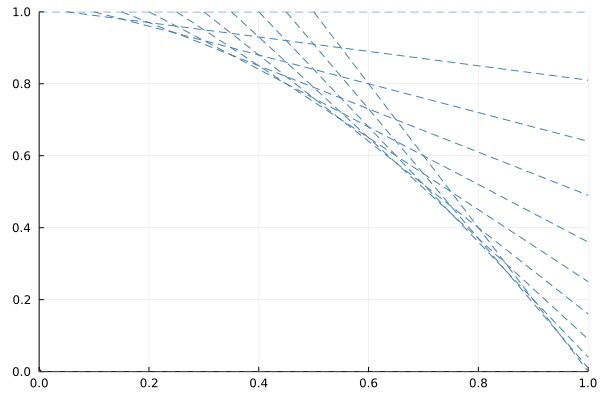

In [6]:
x⁰ = [0, 0];
γ = 0.1;
A, b, xstar = resolve(obj, c, A, sig, b, x_cons, x⁰, γ);
sol = xstar[size(xstar, 1), :];
valor = sum(sol);
println("Solução em $sol, com valor igual a $valor");
cria_gif(A, b, xstar, 0:1, (-Inf, Inf), (-Inf, 1))

In [7]:
c = ones(2, 1);
A = zeros(11, 2);
b = zeros(11, 1);
obj = "Max";
sig = ["<=", "<=", "<=", "<=", "<=", "<=", "<=", "<=", "<=", "<=", "<="];
x_cons = [">=", ">="];
for i in 1:11
    p = (i - 1) / 10
    A[i, :] = [2 * p, 1];
    b[i] = p^2 + 1;
end

Solução em [0.4972871024569691, 0.7525915228205151], com valor igual a 1.2498786252774843


Plots.AnimatedGif("/home/igor/Área de Trabalho/FGV/07 - 7º Semestre/02 - PLI/PLI/A2/temp.gif")
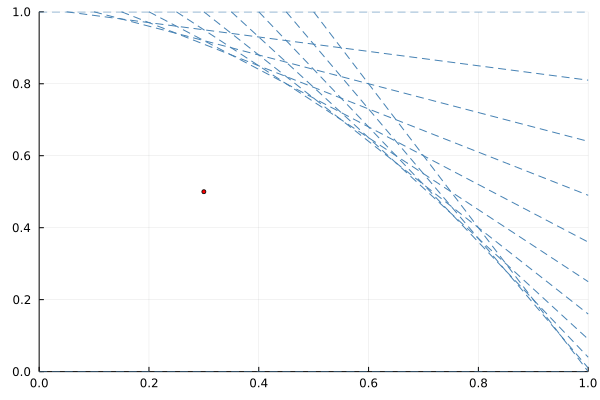

In [8]:
x⁰ = [0.3, 0.5];
γ = 0.1;
A, b, xstar = resolve(obj, c, A, sig, b, x_cons, x⁰, γ);
sol = xstar[size(xstar, 1), :];
valor = sum(sol);
println("Solução em $sol, com valor igual a $valor");
cria_gif(A, b, xstar, 0:1, (-Inf, Inf), (-Inf, 1))

In [9]:
model = Model(GLPK.Optimizer);
@variable(model, x[i = 1:2] >= 0, base_name = "x");
opt_function = @expression(model, ones(2)'*x);
@constraint(model, C, A*x .<= b);
@objective(model, Max, opt_function);

status = JuMP.optimize!(model);
sol = value.(x);
valor = sum(sol);
println("Solução em $sol, com valor igual a $valor");

Solução em [0.5499999999999994, 0.7000000000000006], com valor igual a 1.25


## Exemplo 2

In [10]:
c = [1; 1.5];
A = [2 2; 1 2; 4 2];
b = [160; 120; 280];
obj = "Max";
sig = ["<=", "<=", "<="];
x_cons = [">=", ">="];

Solução em [39.99999119000511, 40.000000000000014], com valor igual a 79.99999119000512


Plots.AnimatedGif("/home/igor/Área de Trabalho/FGV/07 - 7º Semestre/02 - PLI/PLI/A2/temp.gif")
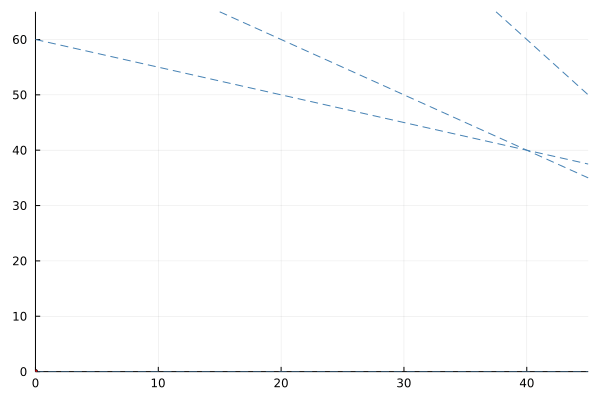

In [11]:
x⁰ = [0.01; 0.01];
γ = 0.5;
A, b, xstar = resolve(obj, c, A, sig, b, x_cons, x⁰, γ);
sol = xstar[size(xstar, 1), :];
valor = sum(sol);
println("Solução em $sol, com valor igual a $valor");
cria_gif(A, b, xstar, 0:45, (-Inf, 45), (-Inf, 65))

In [12]:
c = [1; 1.5];
A = [2 2; 1 2; 4 2];
b = [160; 120; 280];
obj = "Max";
sig = ["<=", "<=", "<="];
x_cons = [">=", ">="];

Solução em [39.999913055613, 40.000000001605], com valor igual a 79.99991305721801


Plots.AnimatedGif("/home/igor/Área de Trabalho/FGV/07 - 7º Semestre/02 - PLI/PLI/A2/temp.gif")
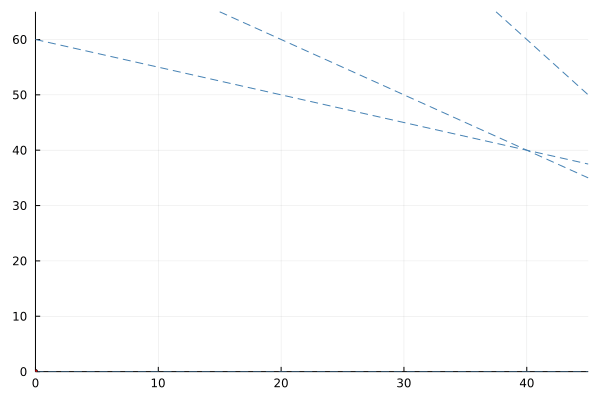

In [13]:
x⁰ = [0.01; 0.01];
γ = 0.1;
A, b, xstar = resolve(obj, c, A, sig, b, x_cons, x⁰, γ);
sol = xstar[size(xstar, 1), :];
valor = sum(sol);
println("Solução em $sol, com valor igual a $valor");
cria_gif(A, b, xstar, 0:45, (-Inf, 45), (-Inf, 65))

In [14]:
model = Model(GLPK.Optimizer);
@variable(model, x[i = 1:2] >= 0, base_name = "x");
opt_function = @expression(model, ones(2)'*x);
@constraint(model, C, A*x .<= b);
@objective(model, Max, opt_function);

status = JuMP.optimize!(model);
sol = value.(x);
valor = sum(sol);
println("Solução em $sol, com valor igual a $valor");

Solução em [60.0, 20.0], com valor igual a 80.0


# Referências

[Karmarkar's algorithm](https://en.wikipedia.org/wiki/Karmarkar's_algorithm)

[Imagem da Passagem de Gois](https://commons.wikimedia.org/wiki/File:France_-_Passage_du_Gois_-_Balise.jpg)

[Imagem da escalada](https://jenikirbyhistory.getarchive.net/amp/media/mountain-climbing-8db762)

[Segundo exemplo](https://www.ufjf.br/epd015/files/2010/06/programacao_linear3.pdf)